# 1 Data Download

In [19]:
# Download Dataset
import os
import zipfile
import gdown

def create_dir(path):
  if os.path.isdir(path):
      print(f"{path} directory exists.")
  else:
      print(f"Did not find {path} directory, creating one...")
      os.mkdir(path, 0o666)

def download_file(url, download_path, file_name):
  create_dir(download_path)
  file_path = os.path.join(download_path, file_name)
  if not os.path.isfile(file_path):
    print(f"Downloading {file_name} to directory {download_path}...")
    gdown.download(url, file_path, quiet=False)

def download_extract_zip(zip_url, download_path, zip_name, extraction_path):
  if not os.path.isdir(extraction_path):
    download_file(zip_url, download_path, zip_name)
    zip_path = os.path.join(download_path, zip_name)
    # Unzip data
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"Unzipping {zip_name} to {extraction_path}...")
        zip_ref.extractall(extraction_path)
  else:
    print(f"File {os.path.join(download_path, zip_name)} already extracted in {extraction_path}...")

# Training Data
csv_name = 'train.csv'
csv_url = 'https://drive.google.com/uc?id=1bI6yuNlP6-NqMup_fWEouIonRfcQq9u5'
#filtered_csv_url = 'https://drive.google.com/uc?id=145mmpfL3q6oCTu6BNoCq0gC9yrnfd40K'

base_path = './data'
cropped_path = os.path.join(base_path, "cropped/")
gauss_path = os.path.join(base_path, "gauss/")
rotated_path = os.path.join(base_path, "rotated/")

cropped_dataset_url = 'https://drive.google.com/uc?id=17SJB_xGObAYutH0PIHAiqO1iZlcHDeIG'
#gauss_dataset_url = 'https://drive.google.com/uc?id=1AeWoFOsYzOudxosqnCWDYGhocA55ZEfk'
#rotated_dataset_url = 'https://drive.google.com/uc?id=1y5QJtYqYiJuGIMpdW96CzskybBjFdAAi'

download_file(csv_url, base_path, csv_name)
download_extract_zip(cropped_dataset_url, base_path, 'cropped.zip', cropped_path)

./data directory exists.


Downloading...
From: https://drive.google.com/uc?id=1bI6yuNlP6-NqMup_fWEouIonRfcQq9u5
To: /content/data/train.csv
100%|██████████| 104k/104k [00:00<00:00, 53.9MB/s]

File ./data/cropped.zip already extracted in ./data/cropped/...


## 2 Data Import & Preprocessing

In [85]:
import pandas as pd
import numpy as np
import json
from PIL import Image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [86]:
# Path to the image directory and CSV file

csv_file = os.path.join(base_path, csv_name)

# Reading the CSV file using Pandas
df = pd.read_csv(csv_file)
df.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


In [87]:
df.describe()

,Image,whaleID
count,4544,4544
unique,4544,447
top,w_7812.jpg,whale_95370
freq,1,47


### Separate Testdata
For the Test Dataset, only Whales are taken which occure more than once in our Train Dataset.

10%: Test  
90%: Train & Validation

In [88]:
# Count occurrences of each whaleID

n_rows = df.shape[0]
print(f"Original Data Size: {n_rows}")
whale_counts = df['whaleID'].value_counts()

n_test = int(0.1 * n_rows)
print(f"Test Data Size: {n_test}")

# Filter rows with whaleID occurring more than n times
n = 1
filtered_df = df[df['whaleID'].isin(whale_counts[whale_counts > n].index)]
test_images = list(filtered_df['Image'].sample(n=n_test, random_state=1))

cleaned_df = df[~df['Image'].isin(test_images)]
print(f"Cleaned Data Size: {cleaned_df.shape[0]}")

# Write test.csv
test_path = os.path.join(base_path, 'test.csv')
df[df['Image'].isin(test_images)].to_csv(test_path, index=False)

Original Data Size: 4544
Test Data Size: 454
Cleaned Data Size: 4090


### Add Augmentated Images to the Training Data

In [90]:
augmentaions = [cropped_path, gauss_path, rotated_path]
augmented_dict = {
    "Image": [],
    "whaleID": []
}

for index, row in cleaned_df.iterrows():
  whale_id = row["whaleID"]
  img = row["Image"]
  for dir in augmentaions:
      img_path = os.path.join(dir, img)
      if os.path.isfile(img_path):
        augmented_dict["Image"].append(img_path)
        augmented_dict["whaleID"].append(whale_id)

cleaned_df = pd.DataFrame(augmented_dict)

In [91]:
cleaned_df

,Image,whaleID
0,./data/cropped/w_7812.jpg,whale_48813
1,./data/cropped/w_4598.jpg,whale_09913
2,./data/cropped/w_3828.jpg,whale_45062
3,./data/cropped/w_8734.jpg,whale_74162
4,./data/cropped/w_3251.jpg,whale_99558
...,...,...
3930,./data/cropped/w_9398.jpg,whale_16406
3931,./data/cropped/w_9399.jpg,whale_09651
3932,./data/cropped/w_9403.jpg,whale_06967
3933,./data/cropped/w_9450.jpg,whale_24458


### Create Whale Lookup Dict
key: whaleID -> whale_48813  
value: respective tensor for that whale -> [ 0, 0, 1, 0, 0, 0 .... 0 ]

In [55]:
# Build a whale id lookup dict with the respective probability tensors
num_classes = len(cleaned_df['whaleID'].unique())
whale_id_dict = {}

for idx, whale_id in enumerate(sorted(data['whaleID'].unique())):
    tensor = torch.zeros(num_classes, dtype=torch.float32)
    tensor[idx] = 1
    whale_id_dict[whale_id] = tensor

def load_image(img_name, folder):
    img_path = os.path.join(folder, img_name)
    if not os.path.exists(img_path):
        return None
    return Image.open(img_path).convert('RGB')

# Sparse Tensor with only one 1 set
whale_id_dict['whale_06967'].shape

torch.Size([447])

In [62]:
# Write JSON to Filesystem
json_file_path = os.path.join(base_path, 'whale_lookup.json' )
with open(json_file_path, 'w') as json_file:
    # Make dict serializable (tensor -> numpy array -> python list)
    json.dump({key: value.numpy().tolist() for key, value in whale_id_dict.items()}, json_file)

In [56]:
num_classes

447

## 3 Dataset and Initialisation

In [92]:
import torchvision.models as models
try:
  from efficientnet_pytorch import EfficientNet
except Exception:
  !pip install efficientnet_pytorch
  from efficientnet_pytorch import EfficientNet

class WhaleDataset:
    def __init__(self, images, labels, whale_tensor_dict, transform=None):
        self.images = images
        self.labels = labels
        self.whale_tensor_dict = whale_tensor_dict
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        whale_id = self.labels[idx]

        try:
            img = Image.open(img_path).convert('RGB')

            if self.transform:
                img = self.transform(img)

            label = self.whale_tensor_dict[whale_id]
            return img, label
        except Exception as e:
            print(e)
            print(whale_id, img_path)

class WhaleEfficientNetB4(nn.Module):
    def __init__(self, num_classes):
        super(WhaleEfficientNetB4, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b4')
        # Set output dimension to num_classes
        self.efficientnet._fc= torch.nn.Linear(
            in_features=self.efficientnet._fc.in_features,
            out_features=num_classes,
            bias=True)

    def forward(self, x):
        logits = self.efficientnet(x)
        return logits

In [93]:
cleaned_df

,Image,whaleID
0,./data/cropped/w_7812.jpg,whale_48813
1,./data/cropped/w_4598.jpg,whale_09913
2,./data/cropped/w_3828.jpg,whale_45062
3,./data/cropped/w_8734.jpg,whale_74162
4,./data/cropped/w_3251.jpg,whale_99558
...,...,...
3930,./data/cropped/w_9398.jpg,whale_16406
3931,./data/cropped/w_9399.jpg,whale_09651
3932,./data/cropped/w_9403.jpg,whale_06967
3933,./data/cropped/w_9450.jpg,whale_24458


In [94]:
from sklearn.model_selection import train_test_split

batch_size = 40

X_train, X_valid, y_train, y_valid = train_test_split(list(cleaned_df["Image"].values), list(cleaned_df["whaleID"].values), test_size=0.2, random_state=42, shuffle=True)

# Define transformations
transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor()
])


# Create dataset and dataloaders
train_dataset = WhaleDataset(X_train, y_train, whale_id_dict, transform)
valid_dataset = WhaleDataset(X_valid, y_valid, whale_id_dict, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5
learning_rate = 0.001

model = WhaleEfficientNetB4(num_classes).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Loaded pretrained weights for efficientnet-b4


### Evaluation Methods

In [131]:
def get_one_hot_matrix(logits, labels):
    # Create a new tensor with zeros
    one_hot_max = torch.zeros_like(logits)
    # Find the index of the maximum value along dimension 1
    max_index = torch.argmax(logits, dim=1)
    # Set the maximum value to 1
    return one_hot_max.scatter_(1, max_index.unsqueeze(1), 1)

def check_correct(logits, labels):
    # Create a new tensor with zeros
    one_hot_max = torch.zeros_like(logits)
    # Find the index of the maximum value along dimension 1
    max_index = torch.argmax(logits, dim=1)
    # Set the maximum value to 1
    one_hot_vector = one_hot_max.scatter_(1, max_index.unsqueeze(1), 1)
    return (torch.all(one_hot_vector == labels, dim=1)).sum().item()

## Training

In [99]:
from tqdm import tqdm

training_loss = []
validation_loss = []
training_accuracy = []
validation_accuruacy = []

for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    # Training
    model.to(device)
    model.train()
    train_loss = []
    train_acc = []

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = model(images)
        loss = criterion(logits, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss.append(loss.item())
        train_acc.append(check_correct(logits, labels) / len(logits))

    epoch_train_loss = sum(train_loss) / len(train_loss)
    epoch_train_acc = sum(train_acc) / len(train_acc)
    training_loss.append(epoch_train_loss)
    training_accuracy.append(epoch_train_acc)

    print('\nEpoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4%}'.format(epoch+1, num_epochs, epoch_train_loss, epoch_train_acc))

    # Validation
    model.eval()
    valid_loss = []
    valid_acc = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            logits = model(images)
            loss = criterion(logits, labels)

            # Calculate training accuracy and loss
            valid_loss.append(loss.item())
            valid_acc.append(check_correct(logits, labels) / len(logits))

    # Print validation statistics
    epoch_valid_loss = sum(valid_loss) / len(valid_loss)
    epoch_valid_acc = sum(valid_acc) / len(valid_acc)
    validation_loss.append(epoch_valid_loss)
    validation_accuruacy.append(epoch_valid_acc)

    print('\nEpoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4%}'.format(epoch+1, num_epochs, epoch_valid_loss, epoch_valid_acc))

Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5], Training Loss: 0.016122, Training Accuracy: 0.8861%


Training Progress:  20%|██        | 1/5 [01:39<06:38, 99.60s/it]

Epoch [1/5], Validation Loss: 0.020064, Validation Accuracy: 1.2500%
Epoch [2/5], Training Loss: 0.015529, Training Accuracy: 1.0127%


Training Progress:  40%|████      | 2/5 [03:24<05:07, 102.48s/it]

Epoch [2/5], Validation Loss: 0.018794, Validation Accuracy: 0.8750%
Epoch [3/5], Training Loss: 0.015182, Training Accuracy: 1.6863%


Training Progress:  60%|██████    | 3/5 [04:59<03:18, 99.28s/it] 

Epoch [3/5], Validation Loss: 0.020245, Validation Accuracy: 0.8750%
Epoch [4/5], Training Loss: 0.014470, Training Accuracy: 4.6745%


Training Progress:  80%|████████  | 4/5 [06:37<01:38, 98.80s/it]

Epoch [4/5], Validation Loss: 0.027386, Validation Accuracy: 2.9954%
Epoch [5/5], Training Loss: 0.013195, Training Accuracy: 10.9946%


Training Progress: 100%|██████████| 5/5 [08:18<00:00, 99.78s/it]

Epoch [5/5], Validation Loss: 0.041698, Validation Accuracy: 4.8704%


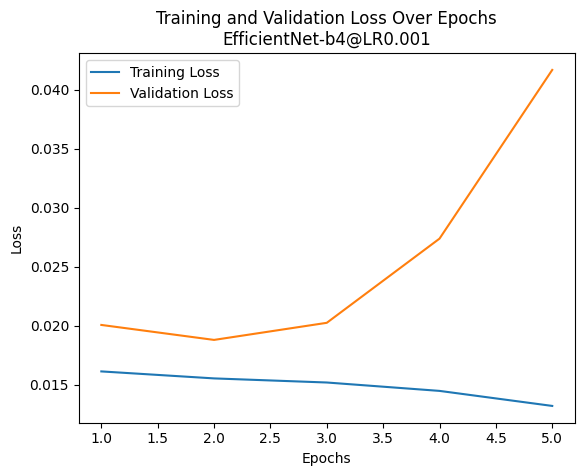

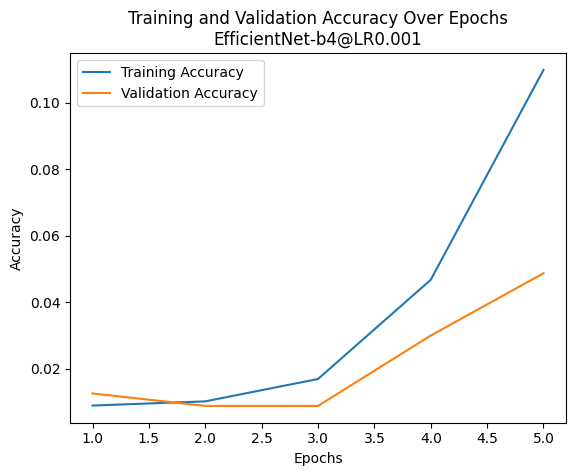

In [105]:
import matplotlib.pyplot as plt

def plot_loss(num_epochs, training_loss, validation_loss):
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title(f'Training and Validation Loss Over Epochs\nEfficientNet-b4@LR{learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(num_epochs, training_accuracy, validation_accuracy):
    epochs = range(1, num_epochs+1)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy Over Epochs\nEfficientNet-b4@LR{learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss(num_epochs, training_loss, validation_loss)
plot_accuracy(num_epochs, training_accuracy, validation_accuruacy)

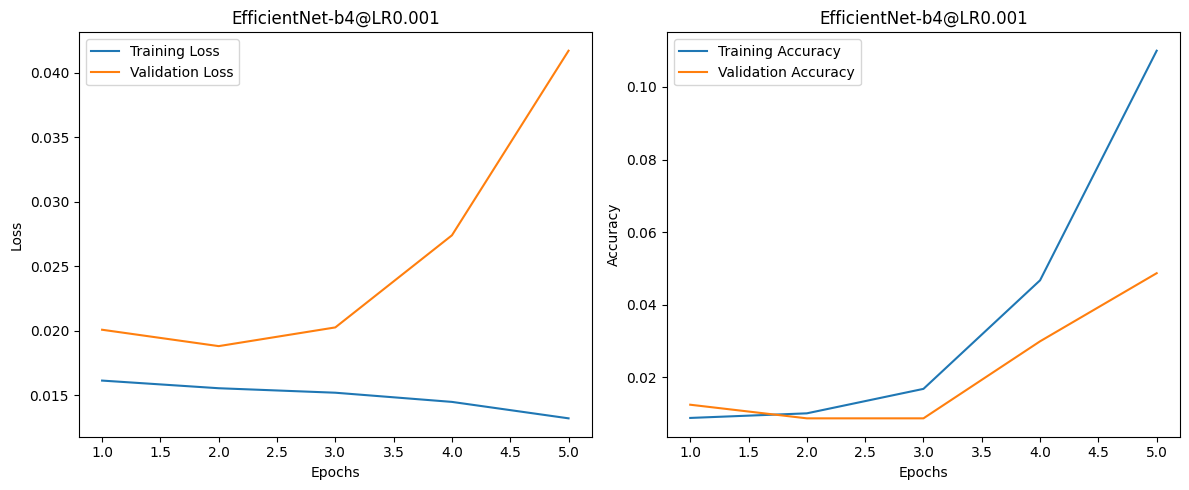

In [109]:
def plot_loss_and_accuracy(num_epochs, training_loss, validation_loss, training_accuracy, validation_accuracy, learning_rate):
    epochs = range(1, num_epochs + 1)
    # Set the figure size to make it broader
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, validation_loss, label='Validation Loss')
    plt.title(f'EfficientNet-b4@LR{learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
    plt.title(f'EfficientNet-b4@LR{learning_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show()

# Example usage:
plot_loss_and_accuracy(num_epochs, training_loss, validation_loss, training_accuracy, validation_accuruacy, learning_rate)

## Testing

In [101]:
test_df = df[df['Image'].isin(test_images)]
test_dataset = WhaleDataset(list(test_df["Image"].values), list(test_df["whaleID"].values), whale_id_dict, transform)
test_loader = DataLoader(train_dataset, batch_size=batch_size)

In [158]:
from sklearn.metrics import f1_score

model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    running_acc = []
    running_f1 = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        running_acc.append(check_correct(logits, labels) / labels.size(0))
        ohm = get_one_hot_matrix(logits, labels).cpu()
        running_f1.append(f1_score(labels.cpu(), ohm, average='micro'))
        all_labels.append(labels.cpu().argmax(dim=1).numpy())
        all_predictions.append(ohm.argmax(dim=1).numpy())
    total_acc = sum(running_acc) / len(test_loader)
    total_f1 = sum(running_f1) / len(test_loader)
    print('Test Dataset {} Accuracy: {:.2f}% F1-Score: {:.2f} '.format(test_df.shape[0], total_acc * 100, total_f1))

Test Dataset 454 Accuracy: 26.36% F1-Score: 0.26 


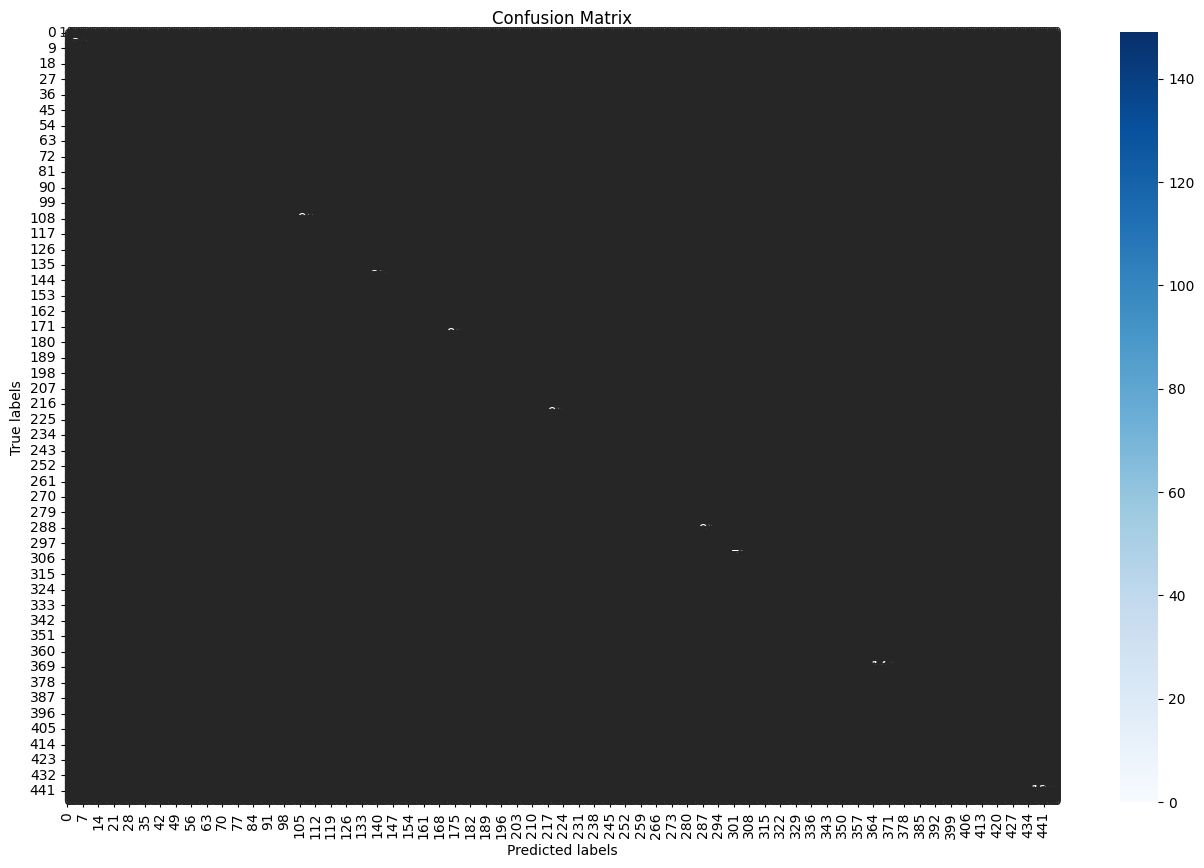

In [160]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

labels = np.concatenate(all_predictions)
predictions = np.concatenate(all_predictions)

# Compute confusion matrix
confusion_mat = confusion_matrix(labels, predictions, labels=list(range(num_classes + 1)))

plt.figure(figsize=(16, 10))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
!ls "/content/drive/MyDrive/AI Project"

In [ ]:
model_save_name = 'vgg19_2811.pt'
path = f"/content/drive/MyDrive/AI Project/{model_save_name}"
torch.save(model.state_dict(), path)

In [ ]:
model_save_name = 'vgg19_2811.pt'
path = f"/content/drive/MyDrive/AI Project/{model_save_name}"
model = WhaleEfficientNetB4(num_classes)
model.load_state_dict(torch.load(path))
model = model.to(device)
model.eval()